In [18]:
# import all the modules 
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Operator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.result import marginal_distribution
import numpy as np 
from qiskit.circuit.library import UGate

#  The teleportation protocol
In this script we will look at the teleportation protocol, which enables us to transmit quantum information froma a sender to a receiver.

In [19]:
# prepare the circuit
# define the three qubits to perform the protocol
Q = QuantumRegister(1, "Q")
A = QuantumRegister(1, "A")
B = QuantumRegister(1, "B")

# define the two classical bits which contain the outcome of the meausure 

a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

In [20]:
# the qubits in order are (B, A, Q), using qiskit convention we can implement the circuit 
circuit  = QuantumCircuit(Q, A, B, a, b)

# first we need to prepare the ebit used for teleportation, in order to create an entangled state we use in succession an hadamard and cx gate 

circuit.h(A)
circuit.cx(A,B)
circuit.barrier()

# we then perform Alice's operation on qubits A and Q 

circuit.cx(Q, A)                # controlled cnot using Q as the control qubit and A as the target
circuit.h(Q)                    # perform an Hadamard operation on qubit A

# we then perform a standard basis meaure on the two qubits and store the information in the classical bits 
# the classical bits are then sent to Bob

circuit.measure(A, a)
circuit.measure(Q, b)
circuit.barrier()

# Bob received the bits and perform an X operation if a = 1, Z operation if b = 1

with circuit.if_test((a,1)):
    circuit.x(B)                # Bob performs an X gate on his qubit if the classical bit a = 1 
with circuit.if_test((b,1)):
    circuit.z(B)

# this operation completes the protocol


/Users/lorenzospera/Library/Python/3.9/lib/python/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


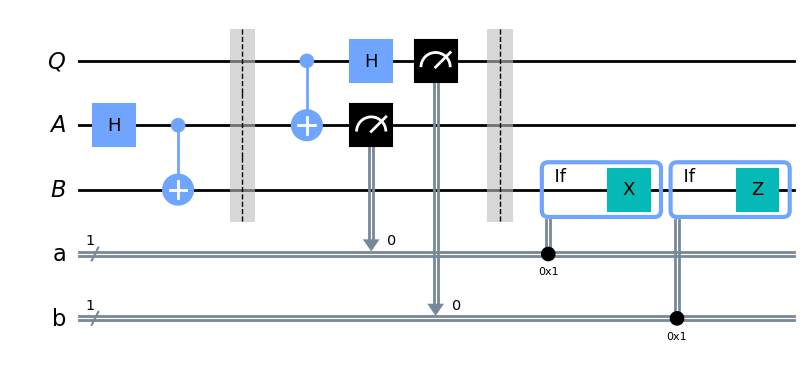

In [21]:
# display the circuit
display(circuit.draw(output = "mpl"))

# Check the result 
We can check that the circuit implements the protocol correctly by applyng a unitary gate $U$ to the initialised $\ket{0}$ state of $Q$ in order to create a random vector to be teleported. This can be done using the UGate function.
In order to check that the protocol in implemented correctly we apply the whole circuit to the initialised random vector and, after Bob's operation we apply the inverse of the gate $U$. If the circuit works correctly we should get the final state to be $\ket{0}$ with absolute certainty. The function UGate implements a unitary operation of the form
$$

U (\theta, \phi, \lambda) = 
\begin{pmatrix}
\cos\left(\frac{\theta}{2}\right)   & e^{-i\lambda}\sin\left(\frac{\theta}{2}\right)\\
e^{i\phi}\sin\left(\frac{\theta}{2}\right)  & e^{i(\phi +\lambda )}\cos\left(\frac{\theta}{2}\right)
\end{pmatrix}
$$


In [22]:
# initialise the random U gate 
t = np.random.uniform(low = 0, high = 2*np.pi)
p = np.random.uniform(low = 0, high = 2*np.pi)
l = np.random.uniform(low = 0, high = 2*np.pi)
random_U_gate  = UGate(theta = t, phi = p, lam = l )

# display the gate 
display(array_to_latex(random_U_gate.to_matrix()))

<IPython.core.display.Latex object>

In [23]:
# we can create the same circuit to check if the implementation is correct with the procedure described above 

test_circuit = QuantumCircuit(Q, A, B, a, b)                # create the same circuit we want to test

# apply the UGate on the qubit Q to initialise a random state 
test_circuit.append(random_U_gate, Q)
test_circuit.barrier()

# we can apply the whole teleportation protocol from before 

test_circuit = test_circuit.compose(circuit)
test_circuit.barrier()

# we can now applt the inverse gate to the qubit B

test_circuit.append(random_U_gate.inverse(), B)
result = ClassicalRegister(1, "Result")
test_circuit.add_register(result)
test_circuit.measure(B, result)                             # measure the qubit B and store the result in a classical bit 

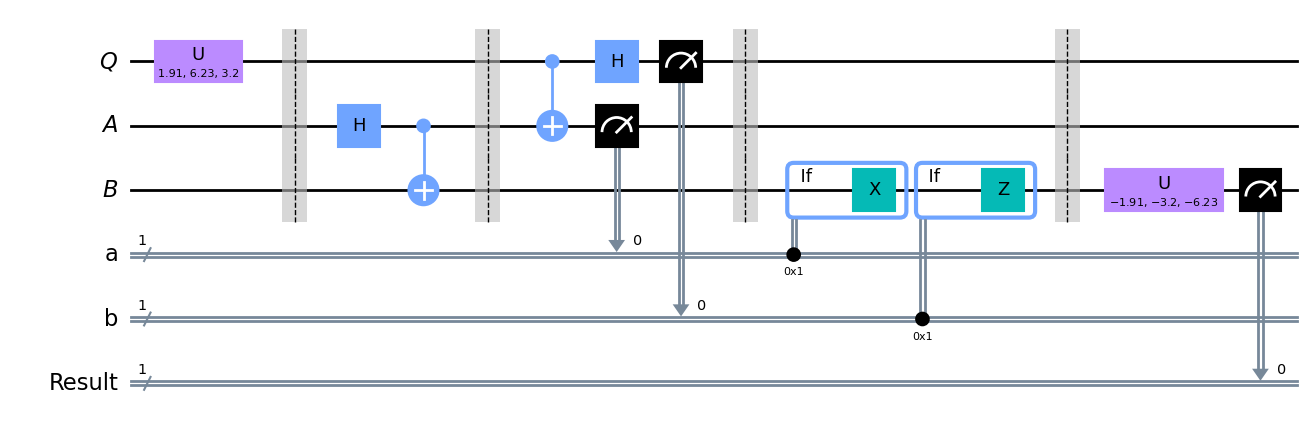

In [24]:
# display the circuit as a whole
display(test_circuit.draw(output = "mpl"))

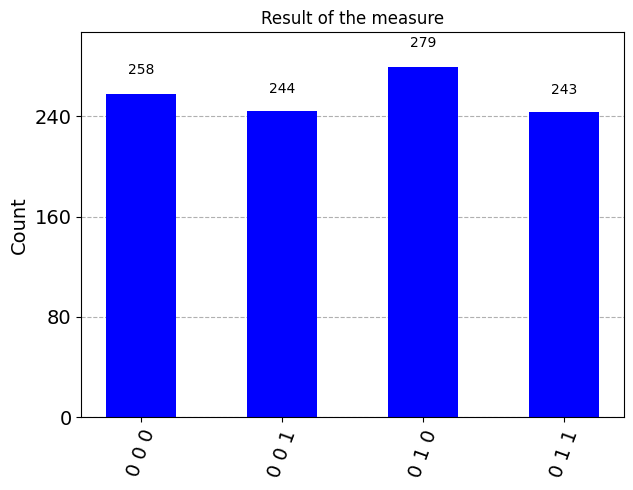

In [25]:
# as we did before we can simulate the circuit using the aer simulator 
result = AerSimulator().run(test_circuit).result()
statistics = result.get_counts()

# in this way we are making a standard basis measurment on the final state of the system 

# display the result 
plot_histogram(statistics, color = "blue", title = 'Result of the measure')

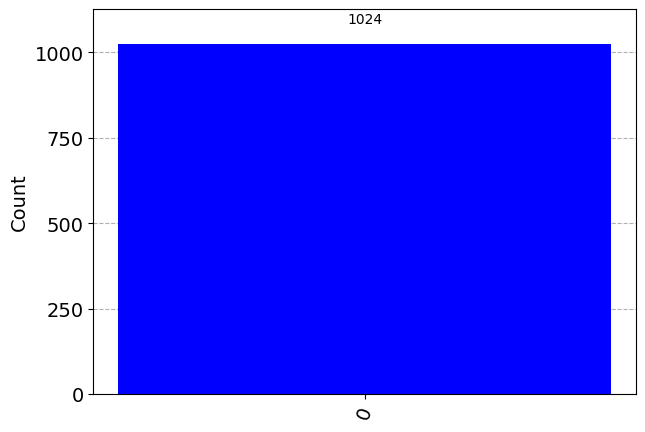

In [26]:
# we can also select only the statistics on the test result qubit 
result_statistics = marginal_distribution(statistics, [2])
# display the result 
plot_histogram(result_statistics, color = "blue")

# Superdense coding 

In [27]:
# generate the two classical bits randomly, call them c and d 
c = np.random.randint(0,2)
d = np.random.randint(0,2)
print(d, c)

0 0


In [28]:
# create the circuit that implements the protocol
# define the 2 qubits for alice and bob

A = QuantumRegister(1, "A") 
B = QuantumRegister(1, "B") 
protocol = QuantumCircuit(A,B)

# first of all create the entangle bit using A and B as we did before 

protocol.h(A)
protocol.cx(A,B)
protocol.barrier()

# implement Alice's operations 

if d == 1:
    protocol.z(A)
if c == 1:
    protocol.x(A)
protocol.barrier()

# implement Bob's operation

protocol.cx(A,B)
protocol.h(A)
protocol.barrier()

# perform the standard basis measurments
c_result = ClassicalRegister(1, "c result")
d_result = ClassicalRegister(1, "d result")
protocol.add_register(c_result)
protocol.add_register(d_result)
protocol.measure(A, d_result)
protocol.measure(B, c_result)
protocol.barrier()

# we could have also used the method protocol.meausure_all()



/Users/lorenzospera/Library/Python/3.9/lib/python/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


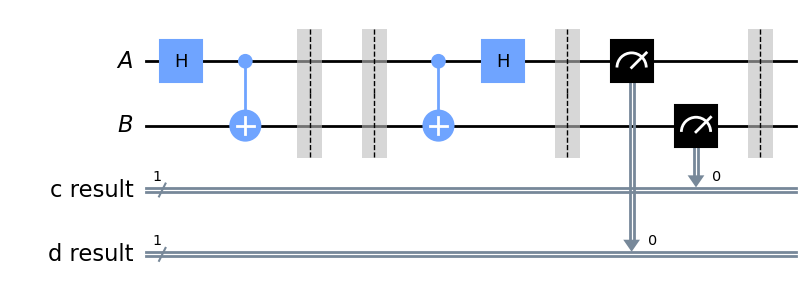

In [29]:
display(protocol.draw("mpl"))

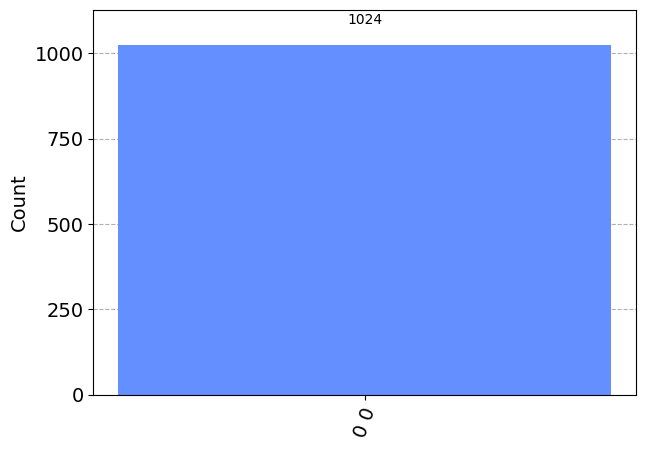

In [33]:
# display the result 
result = AerSimulator().run(protocol).result()
statistics = result.get_counts()
plot_histogram(statistics)


This is not the only way we can implement random bits in the circuit (by using the numpy random generator). The same task can be accomplished by using an additional qubit and two classical bits to store information. The operation is quite simple. We use the $rgb$ (random generating bit) to generate the bits $c$ and $d$ for Alice.
We take a general qubit, use an Hadamard gate, measure and store the result in $d$ and then do the same for the bit $c$.

/Users/lorenzospera/Library/Python/3.9/lib/python/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


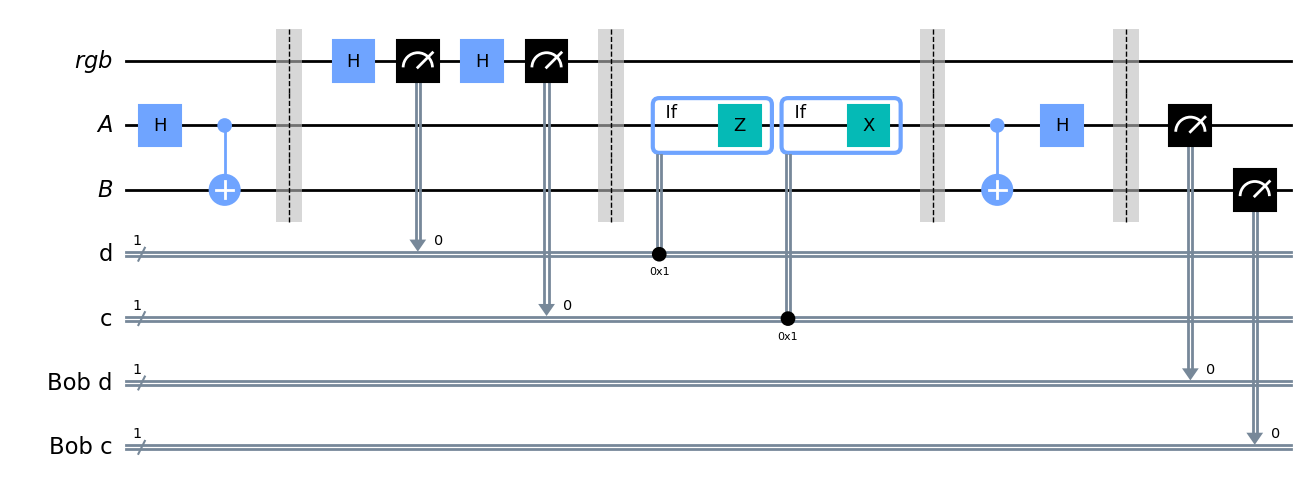

In [31]:
rgb =  QuantumRegister(1, "rgb")
A = QuantumRegister(1, "A")
B = QuantumRegister(1, "B")
c = ClassicalRegister(1, "c")
d = ClassicalRegister(1, "d")

test = QuantumCircuit(rgb , A, B,  d, c)

# initialise the entangled bit of information 
test.h(A)
test.cx(A,B)
test.barrier()

# generate at random the 2 classical bits 

test.h(rgb)
test.measure(rgb, d)            # store the classical bit
test.h(rgb)
test.measure(rgb, c)
test.barrier() 

# Alice's operations

with test.if_test((d, 1), label="Z"):
    test.z(A)
with test.if_test((c, 1), label="X"):
    test.x(A)
test.barrier()

# Bob's operations 

test.cx(A, B)
test.h(A)
test.barrier()
Bob_c = ClassicalRegister(1, "Bob c")
Bob_d = ClassicalRegister(1, "Bob d")
test.add_register(Bob_d)
test.add_register(Bob_c)
test.measure(A, Bob_d)
test.measure(B, Bob_c)

display(test.draw(output="mpl"))



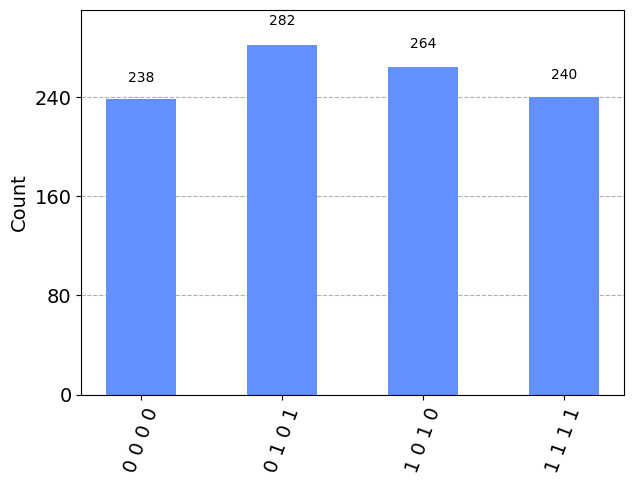

In [32]:
# display the result 
result = AerSimulator().run(test).result()
statistics = result.get_counts()
plot_histogram(statistics)